In [6]:
import numpy as np
from scipy.stats import multivariate_normal
import sim_framework as sf 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.tri as tri
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import matplotlib.path as mpath


### Helper functions

In [20]:
def create_contour_plot(x, y, z, xlabel, ylabel, title, legend_label):
    """
    Create a smoothed contour plot.

    Parameters:
    - x: Array-like sequence of x-coordinates (e.g., heritability).
    - y: Array-like sequence of y-coordinates (e.g., phenotypic correlation).
    - z: Array-like sequence of values at the x, y coordinates (e.g., fraction of variants recovered).
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - title: Title of the plot.
    - legend_label: Label for the color bar legend.
    """
    
    # Create grid coordinates
    xi = np.linspace(min(x), max(x), 75)  # 100 points for smoothness can be adjusted
    yi = np.linspace(min(y), max(y), 75)  # 100 points for smoothness can be adjusted
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate unstructured D-dimensional data to the points on the grid
    Zi = griddata((x, y), z, (Xi, Yi), method='linear')  # Other methods include 'linear' and 'nearest'

    # Create the contour plot using the denser grid and interpolated data
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(
        Xi,
        Yi,
        Zi,
        levels=np.linspace(0, 1, 500),  # Modify the levels for more or fewer contours
        cmap='viridis',
        vmin=0,
        vmax=1 
    )

    # Add a color bar with the specified legend label
    #plt.colorbar(contour, label=legend_label)
    plt.colorbar(contour)

    # Set the provided axis labels and title
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(title, fontsize = 15)

    # Show the plot
    plt.show()





### Upstream biomarkers

In [24]:
N, n, m, k = 25000, 100, 5, 0
n_B, n_P, n_BP = 50, 0, 0
n_pd = 25
sigma_pd = 0.5
p = 0.25
sigma_P, sigma_BP = 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1, 1
correlations = np.arange(0.01, 0.5, 0.05)
sigma_B = np.logspace(-3, 3, len(correlations))
env_variance = np.array([0.001])
n_rep = 10  # Number of repetitions

x_avg = []
y_avg = []
z_avg = []
z2_avg = []
z3_avg = []

for i in range(len(correlations)):
    correlation_matrix = np.reshape(np.array([correlations[i].tolist()] * m), (1, m))
    for j in range(len(sigma_B)):

        # Initialize variables to accumulate results for each repetition
        x_rep = []
        y_rep = []
        z_rep = []
        z2_rep = []
        z3_rep = []

        for rep in range(n_rep):
            # Perform the simulation
            results = sf.simulate_phenotypes_and_biomarkers_with_correlations(N, n, m, k, n_B, n_P, n_BP, p,
                                                                              sigma_B[j], sigma_P, sigma_BP,
                                                                              sigma_epsilon_B, sigma_epsilon_P)

            B, _, h2_B, _, _, _, _, G, causal_indices_B, _, E_B, _, _, _ = results
            y_rep.append(np.mean(h2_B).tolist())

            B = (B - np.mean(B, axis=0)) / np.std(B, axis=0)
            
            P, h2_pd_direct, h2_pd_indirect, causal_indices_pd = sf.simulate_downstream_phenotypes_with_direct_genetic_effects(
                N, G, B, correlation_matrix, env_variance, 0, sigma_pd, causal_indices_B)
            
            P_hat = sf.fit_regression(P, B)
            
            results2 = sf.run_gwas_return_metrics(P_hat, G, causal_indices_B.T, None)
            _, _, TPR, FPR, _, FDR = results2
            
            z_rep.append(TPR)
            z2_rep.append(FPR)
            z3_rep.append(FDR)
            
            x_rep.append(h2_pd_direct + h2_pd_indirect)

        # Store the average of the results for the given correlation and sigma_B
        x_avg.append(np.mean(x_rep))
        y_avg.append(np.mean(y_rep))
        z_avg.append(np.mean(z_rep))
        z2_avg.append(np.mean(z2_rep))
        z3_avg.append(np.mean(z3_rep))

x_avg = np.array(x_avg)
y_avg = np.array(y_avg)
z_avg = np.array(z_avg)
z2_avg = np.array(z2_avg)
z3_avg = np.array(z3_avg)


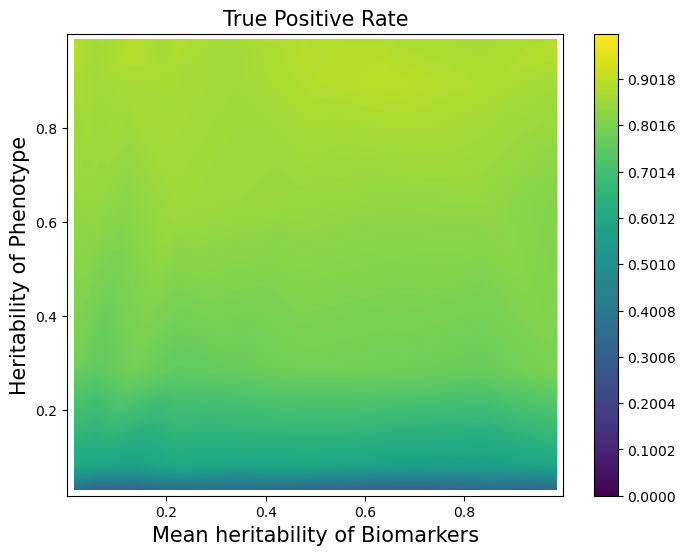

In [25]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='True Positive Rate'
legend_label='True Positive Rate'

create_contour_plot(x_avg, y_avg, z_avg, xlabel, ylabel, title, legend_label)

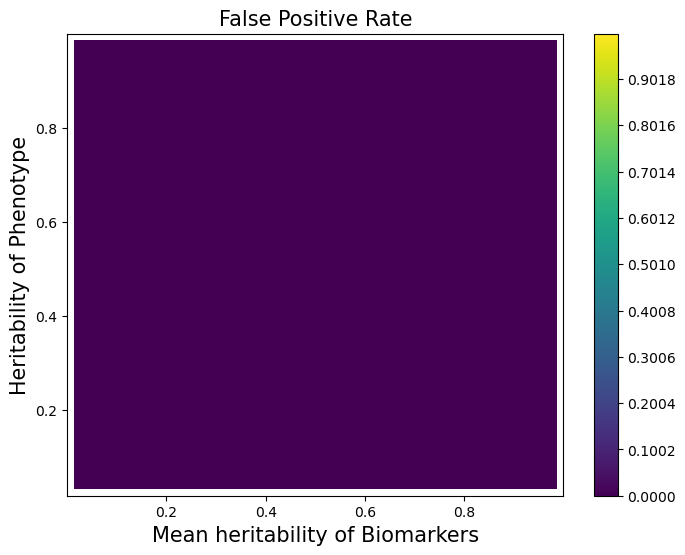

In [26]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Positive Rate'
legend_label='False Positive Rate'

create_contour_plot(x_avg, y_avg, z2_avg, xlabel, ylabel, title, legend_label)

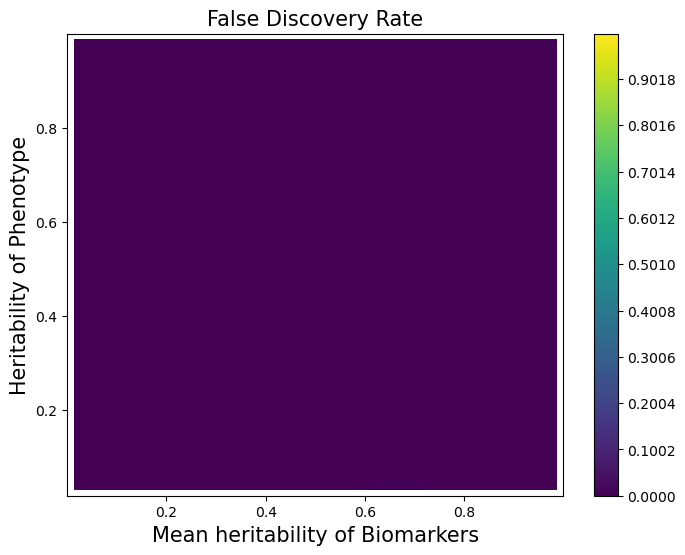

In [27]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Discovery Rate'
legend_label='False Discovery Rate'

create_contour_plot(x_avg, y_avg, z3_avg, xlabel, ylabel, title, legend_label)

### Upstream biomarkers with direct genetic effects 

In [ ]:
# Define the parameters
N, n, m, k = 25000, 100, 5, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
n_pd = 25
sigma_pd = 0.01
sigma_P, sigma_BP = 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1, 1
correlations = np.arange(0.01, 0.9, 0.05)
sigma_B = np.logspace(-3, 3, len(correlations))
env_variance = np.array([0.001])
n_rep = 10  # Number of repetitions

# Initialize lists to store average results
x_down_dir_avg = []
y_down_dir_avg = []
z_down_dir_avg = []
z2_down_dir_avg = []
z3_down_dir_avg = []

# Loop over parameter combinations
for i in range(len(correlations)):
    correlation_matrix = np.reshape(np.array([correlations[i].tolist()] * m), (1, m))
    for j in range(len(sigma_B)):

        # Initialize temporary lists for repetition results
        x_rep = []
        y_rep = []
        z_rep = []
        z2_rep = []
        z3_rep = []

        for rep in range(n_rep):
            results = sf.simulate_phenotypes_and_biomarkers_with_correlations(
                N, n, m, k, n_B, n_P, n_BP, p, sigma_B[j], sigma_P, sigma_BP,
                sigma_epsilon_B, sigma_epsilon_P
            )
            B, _, h2_B, _, _, _, _, G, causal_indices_B, _, E_B, _, _, _ = results
            B = (B - np.mean(B, axis=0)) / np.std(B, axis=0)


            P, h2_pd_direct, h2_pd_indirect, causal_indices_pd = sf.simulate_downstream_phenotypes_with_direct_genetic_effects(
            N, G, B, correlation_matrix, env_variance, n_pd, sigma_pd, causal_indices_B)

            h2_P = h2_pd_direct + h2_pd_indirect

            y_rep.append(h2_P)
            x_rep.append(h2_B)
            
            causal_indices_P = np.concatenate((causal_indices_B, causal_indices_pd))
            
            P_hat = sf.fit_regression(P, B)
            results2 = sf.run_gwas_return_metrics(P_hat, G, causal_indices_P.T, None)
            _, _, TPR, FPR, _, FDR = results2
            
            z_rep.append(TPR)
            z2_rep.append(FPR)
            z3_rep.append(FDR)

        # Calculate the average across all repetitions
        x_down_dir_avg.append(np.mean(x_rep))
        y_down_dir_avg.append(np.mean(y_rep))
        z_down_dir_avg.append(np.mean(z_rep))
        z2_down_dir_avg.append(np.mean(z2_rep))
        z3_down_dir_avg.append(np.mean(z3_rep))

# Convert lists to NumPy arrays
x_down_dir_avg = np.array(x_down_dir_avg)
y_down_dir_avg = np.array(y_down_dir_avg)
z_down_dir_avg = np.array(z_down_dir_avg)
z2_down_dir_avg = np.array(z2_down_dir_avg)
z3_down_dir_avg = np.array(z3_down_dir_avg)

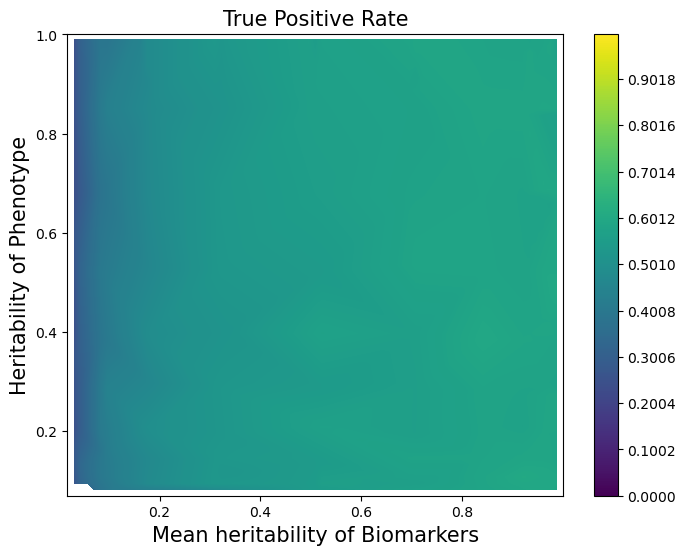

In [21]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='True Positive Rate'
legend_label='True Positive Rate'

create_contour_plot(x_down_dir_avg, y_down_dir_avg, z_down_dir_avg, xlabel, ylabel, title, legend_label)

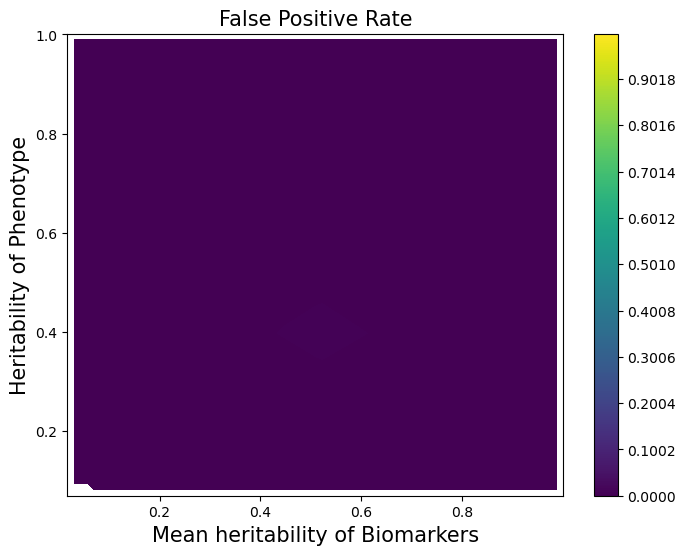

In [22]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Positive Rate'
legend_label='False Positive Rate'

create_contour_plot(x_down_dir_avg, y_down_dir_avg, z2_down_dir_avg, xlabel, ylabel, title, legend_label)

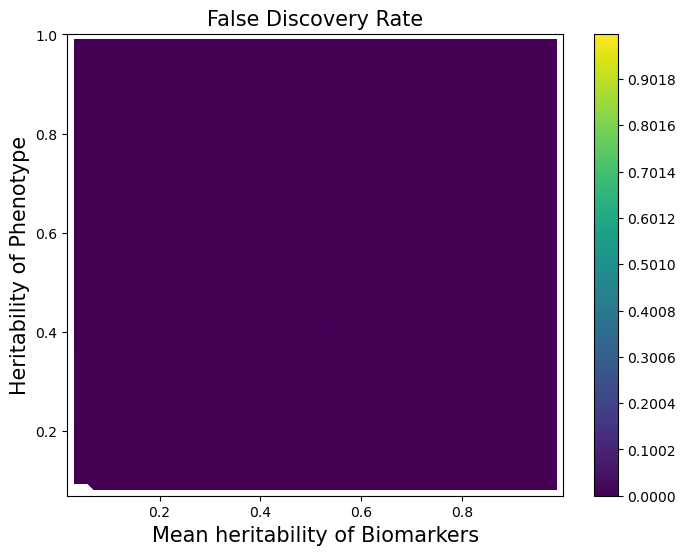

In [23]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Discovery Rate'
legend_label='False Discovery Rate'

create_contour_plot(x_down_dir_avg, y_down_dir_avg, z3_down_dir_avg, xlabel, ylabel, title, legend_label)

### Downstream biomarkers

In [28]:
N, n, m, k = 25000, 100, 1, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
n_pd = 0
sigma_pd = 0.25
sigma_P, sigma_BP = 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1, 1
correlations = np.arange(0.01, 0.9, 0.05)
sigma_B = np.logspace(-3, 3, len(correlations))
m2 = 5  # number of downstream biomarkers 
env_variance = np.array([0.001])
n_rep = 10  # Number of repetitions

x_down_avg = []
y_down_avg = []
z_down_avg = []
z2_down_avg = []
z3_down_avg = []

for i in range(len(correlations)):
    correlation_matrix = np.reshape(np.array([correlations[i].tolist()] * m), (1, m))
    for j in range(len(sigma_B)):

        # Initialize variables to store the results of each repetition
        x_rep = []
        y_rep = []
        z_rep = []
        z2_rep = []
        z3_rep = []

        for rep in range(n_rep):
            results = sf.simulate_phenotypes_and_biomarkers_with_correlations(
                N, n, m, k, n_B, n_P, n_BP, p, sigma_B[j], sigma_P, sigma_BP,
                sigma_epsilon_B, sigma_epsilon_P
            )
            P, _, h2_P, _, _, _, _, G, causal_indices_P, _, E_P, _, _, _ = results
            
            P = (P - np.mean(P, axis=0)) / np.std(P, axis=0)
            
            h2_B = 0
            downstream_biomarkers = []
            for _ in range(m2):
                B, h2_B_direct, h2_B_indirect, causal_indices_B = sf.simulate_downstream_phenotypes_with_direct_genetic_effects(
                    N, G, P, correlation_matrix, env_variance, n_pd, sigma_pd, causal_indices_P
                )
                downstream_biomarkers.append(B)
                h2_B += h2_B_direct + h2_B_indirect
            
            B = np.concatenate(downstream_biomarkers, axis=1)
            h2_B = h2_B / m2
            
            y_rep.append(h2_P)
            x_rep.append(h2_B)
            
            P_hat = sf.fit_regression(P, B)
            results2 = sf.run_gwas_return_metrics(P_hat, G, causal_indices_P.T, None)
            _, _, TPR, FPR, _, FDR = results2
            
            z_rep.append(TPR)
            z2_rep.append(FPR)
            z3_rep.append(FDR)

        # Store the average of the results for the given correlation and sigma_B
        x_down_avg.append(np.mean(x_rep))
        y_down_avg.append(np.mean(y_rep))
        z_down_avg.append(np.mean(z_rep))
        z2_down_avg.append(np.mean(z2_rep))
        z3_down_avg.append(np.mean(z3_rep))

x_down_avg = np.array(x_down_avg)
y_down_avg = np.array(y_down_avg)
z_down_avg = np.array(z_down_avg)
z2_down_avg = np.array(z2_down_avg)
z3_down_avg = np.array(z3_down_avg)

        

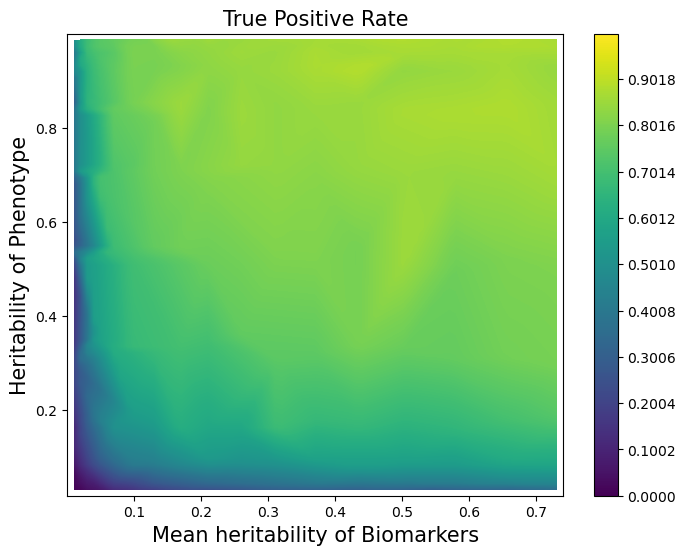

In [36]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='True Positive Rate'
legend_label='Fraction of Causal Variants Recovered'

create_contour_plot(x_down_avg, y_down_avg, z_down_avg, xlabel, ylabel, title, legend_label)

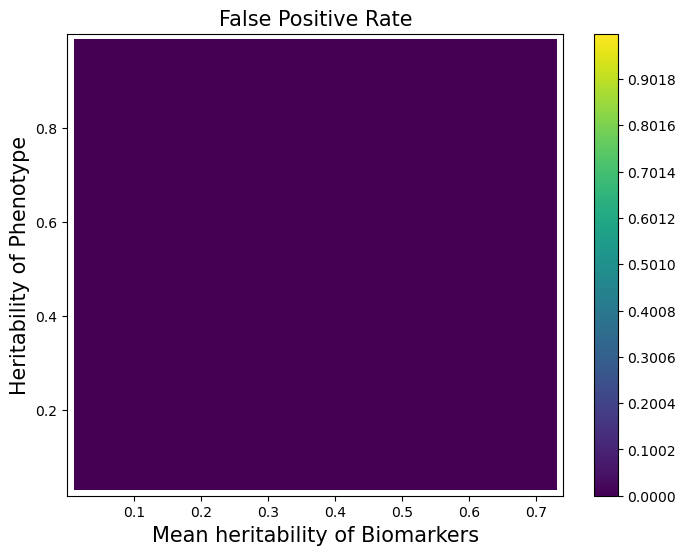

In [30]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Positive Rate'
legend_label='False Positive Rate'

create_contour_plot(x_down_avg, y_down_avg, z2_down_avg, xlabel, ylabel, title, legend_label)

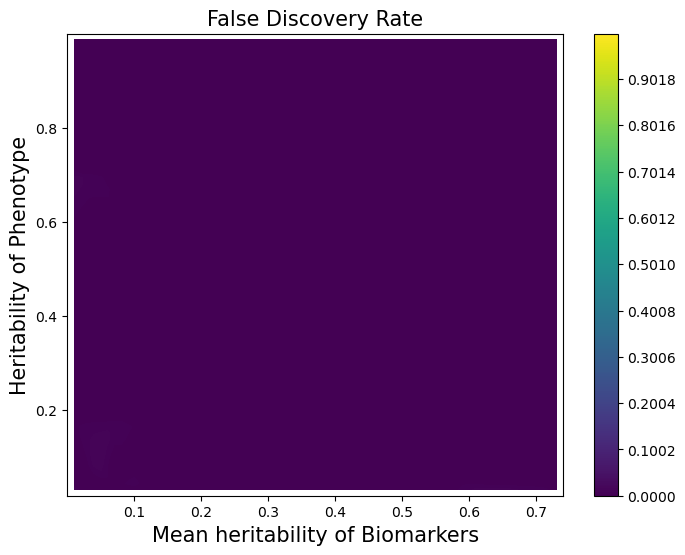

In [31]:
xlabel='Mean heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Discovery Rate'
legend_label='False Discovery Rate'

create_contour_plot(x_down_avg, y_down_avg, z3_down_avg, xlabel, ylabel, title, legend_label)

### Downstream biomarkers with direct genetic effects 

In [32]:
# Define the parameters
N, n, m, k = 25000, 100, 1, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
n_pd = 25
sigma_pd = 0.01
sigma_P, sigma_BP = 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1, 1
correlations = np.arange(0.01, 0.9, 0.05)
sigma_B = np.logspace(-3, 3, len(correlations))
m2 = 5  # Number of downstream biomarkers 
env_variance = np.array([0.001])
n_rep = 10  # Number of repetitions

# Initialize lists to store average results
x_down_dir_avg = []
y_down_dir_avg = []
z_down_dir_avg = []
z2_down_dir_avg = []
z3_down_dir_avg = []

# Loop over parameter combinations
for i in range(len(correlations)):
    correlation_matrix = np.reshape(np.array([correlations[i].tolist()] * m), (1, m))
    for j in range(len(sigma_B)):

        # Initialize temporary lists for repetition results
        x_rep = []
        y_rep = []
        z_rep = []
        z2_rep = []
        z3_rep = []

        for rep in range(n_rep):
            results = sf.simulate_phenotypes_and_biomarkers_with_correlations(
                N, n, m, k, n_B, n_P, n_BP, p, sigma_B[j], sigma_P, sigma_BP,
                sigma_epsilon_B, sigma_epsilon_P
            )
            P, _, h2_P, _, _, _, _, G, causal_indices_P, _, E_P, _, _, _ = results
            P = (P - np.mean(P, axis=0)) / np.std(P, axis=0)

            h2_B = 0  # Reset h2_B for each combination
            downstream_biomarkers = []

            # Simulate and concatenate downstream biomarkers
            for _ in range(m2):
                B, h2_B_direct, h2_B_indirect, causal_indices_B = sf.simulate_downstream_phenotypes_with_direct_genetic_effects(
                    N, G, P, correlation_matrix, env_variance, n_pd, sigma_pd, causal_indices_P
                )
                downstream_biomarkers.append(B)
                h2_B += h2_B_indirect #+ h2_B_direct

            B = np.concatenate(downstream_biomarkers, axis=1)
            h2_B /= m2  # Average the h2_B value

            y_rep.append(h2_P)
            x_rep.append(h2_B)
            
            P_hat = sf.fit_regression(P, B)
            results2 = sf.run_gwas_return_metrics(P_hat, G, causal_indices_P.T, None)
            _, _, TPR, FPR, _, FDR = results2
            
            z_rep.append(TPR)
            z2_rep.append(FPR)
            z3_rep.append(FDR)

        # Calculate the average across all repetitions
        x_down_dir_avg.append(np.mean(x_rep))
        y_down_dir_avg.append(np.mean(y_rep))
        z_down_dir_avg.append(np.mean(z_rep))
        z2_down_dir_avg.append(np.mean(z2_rep))
        z3_down_dir_avg.append(np.mean(z3_rep))

# Convert lists to NumPy arrays
x_down_dir_avg = np.array(x_down_dir_avg)
y_down_dir_avg = np.array(y_down_dir_avg)
z_down_dir_avg = np.array(z_down_dir_avg)
z2_down_dir_avg = np.array(z2_down_dir_avg)
z3_down_dir_avg = np.array(z3_down_dir_avg)



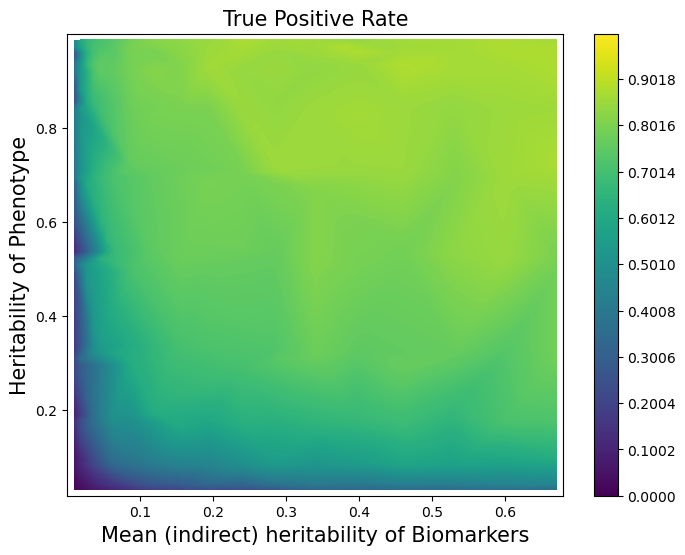

In [37]:
xlabel='Mean (indirect) heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='True Positive Rate'
legend_label='Fraction of Causal Variants Recovered'

create_contour_plot(x_down_dir_avg, y_down_dir_avg, z_down_dir_avg, xlabel, ylabel, title, legend_label)

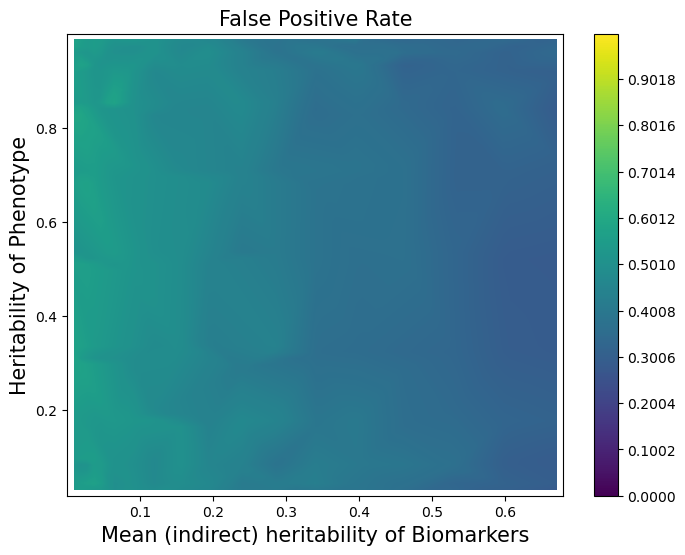

In [34]:
xlabel='Mean (indirect) heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Positive Rate'
legend_label='False Positive Rate'

create_contour_plot(x_down_dir_avg, y_down_dir_avg, z2_down_dir_avg, xlabel, ylabel, title, legend_label)

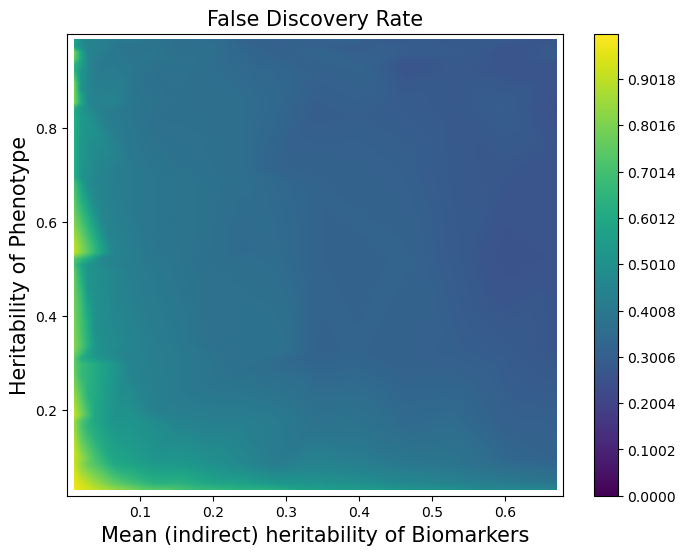

In [35]:
xlabel='Mean (indirect) heritability of Biomarkers'
ylabel='Heritability of Phenotype'
title='False Discovery Rate'
legend_label='False Discovery Rate'

create_contour_plot(x_down_dir_avg, y_down_dir_avg, z3_down_dir_avg, xlabel, ylabel, title, legend_label)